In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp

from numpy.polynomial.hermite import hermgauss
from scipy import optimize

from vb_lib import structure_model_lib, data_utils, plotting_utils
import vb_lib.structure_optimization_lib as s_optim_lib 
import vb_lib.structure_preconditioned_optimization_lib as s_poptim_lib 

import paragami

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import cluster_quantities_lib, modeling_lib


/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp
onp.random.seed(53453)

# Draw data

In [3]:
n_obs = 50
n_loci = 100
n_pop = 4

In [4]:
g_obs, true_pop_allele_freq, true_ind_admix_propn = \
    data_utils.draw_data(n_obs, n_loci, n_pop)

Generating datapoints  0  to  50


In [5]:
g_obs = np.array(g_obs)

Text(0.5, 0, 'individual')

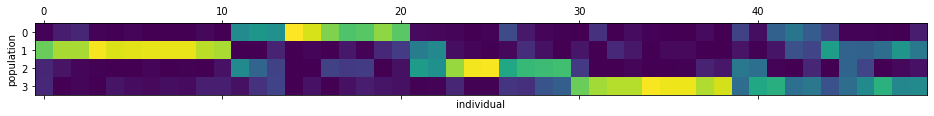

In [6]:
plt.matshow(true_ind_admix_propn.T)
plt.ylabel('population')
plt.xlabel('individual')

In [7]:
g_obs.shape

(50, 100, 3)

# Get prior

In [8]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_paragami)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

OrderedDict:
	[dp_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_beta] = NumericArrayPattern (1,) (lb=0.0, ub=inf)


# Get VB params 

In [9]:
k_approx = 8

In [10]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [11]:
use_logitnormal_sticks = False

vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx,
                                    use_logitnormal_sticks = use_logitnormal_sticks)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (100, 8, 2) (lb=0.0, ub=inf)
	[ind_admix_params] = OrderedDict:
	[stick_beta] = NumericArrayPattern (50, 7, 2) (lb=0.0, ub=inf)


## Initialize 

In [12]:
vb_params_dict = s_optim_lib.set_init_vb_params(g_obs, k_approx, vb_params_dict, prior_params_dict,
                                                seed = 34221)

running NMF ...
running a few cavi steps for pop beta ...
done. Elapsed: 4.95741


Text(0.5, 0, 'individual')

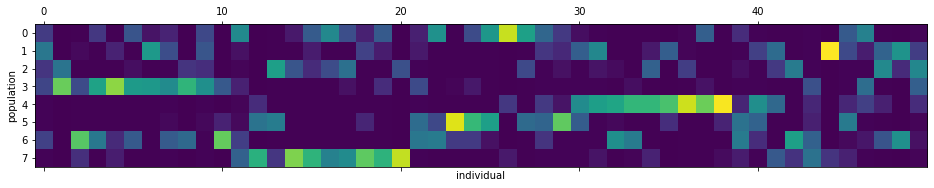

In [13]:
plt.matshow(plotting_utils.get_vb_expectations(vb_params_dict)[0].transpose())
plt.ylabel('population')
plt.xlabel('individual')

# Optimize

In [14]:
# optimize with preconditioner 
vb_opt_dict, vb_opt, out, precond_objective = \
    s_poptim_lib.optimize_structure(g_obs, 
                        vb_params_dict, 
                        vb_params_paragami,
                        prior_params_dict,
                        gh_loc, gh_weights)

compiling objectives ... 
done. Elasped: 19.2165
compiling preconditioned objective ... 
done. Elasped: 32.4549
Run a few iterations without preconditioning ... 
iteration [20]; kl:7528.559787; elapsed: 0.8843secs
iteration [40]; kl:7477.122101; elapsed: 1.5182secs
iteration [60]; kl:7472.873021; elapsed: 1.385secs
iteration [80]; kl:7472.430534; elapsed: 1.5096secs
iteration [98]; kl:7472.425202; elapsed: 1.3729secs
done. Elapsed 6.7083


In [16]:
from bnpmodeling_runjingdev.optimization_lib import run_lbfgs

In [17]:
# optimize without preconditioner: 
# this is old code

optim_objective, init_vb_free = \
    s_optim_lib.define_structure_objective(g_obs, 
                        vb_params_dict,
                        vb_params_paragami,
                        prior_params_dict,
                        gh_loc = gh_loc,
                        gh_weights = gh_weights)

out = run_lbfgs(optim_objective, init_vb_free)

vb_opt2 = out.x
vb_opt_dict2 = vb_params_paragami.fold(vb_opt, free = True)

Compiling objective ...
Iter 0: f = 11956.77972362
Compiling grad ...
Compile time: 17.6427secs

Running L-BFGS-B ... 
Iter 0: f = 11956.77972362
Iter 1: f = 11573.89810952
Iter 2: f = 9422.95663599
Iter 3: f = 8841.92112360
Iter 4: f = 8138.34436641
Iter 5: f = 7842.17416199
Iter 6: f = 7728.43360874
Iter 7: f = 7675.48906898
Iter 8: f = 7630.58650222
Iter 9: f = 7609.20794265
Iter 10: f = 7591.88719462
Iter 11: f = 7575.75263852
Iter 12: f = 7564.62379921
Iter 13: f = 7558.71093443
Iter 14: f = 7551.31798501
Iter 15: f = 7546.72540894
Iter 16: f = 7540.10546099
Iter 17: f = 7538.54357336
Iter 18: f = 7533.00740859
Iter 19: f = 7530.85751517
Iter 20: f = 7528.55978672
Iter 21: f = 7525.89445635
Iter 22: f = 7523.05529332
Iter 23: f = 7519.23808982
Iter 24: f = 7528.48847157
Iter 25: f = 7514.66422530
Iter 26: f = 7509.41596425
Iter 27: f = 7500.21336499
Iter 28: f = 7492.12500834
Iter 29: f = 7487.84282520
Iter 30: f = 7485.36308101
Iter 31: f = 7483.21002559
Iter 32: f = 7481.4698255

# Check out the fit

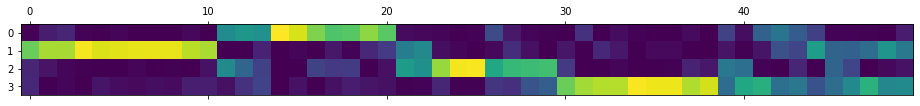

In [18]:
# truth
plt.matshow(true_ind_admix_propn.T)

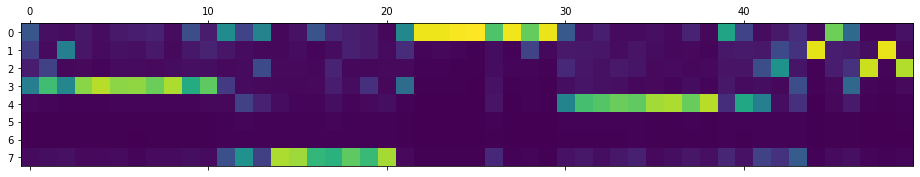

In [19]:
# fitted
e_ind_admix = plotting_utils.get_vb_expectations(vb_opt_dict)[0]
plt.matshow(e_ind_admix.T)

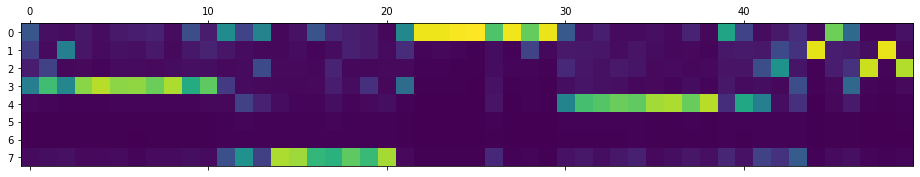

In [20]:
# fitted
e_ind_admix = plotting_utils.get_vb_expectations(vb_opt_dict2)[0]
plt.matshow(e_ind_admix.T)

In [22]:
np.abs(vb_opt - vb_opt2).max()

DeviceArray(0.01165038, dtype=float64)

In [27]:
np.abs(precond_objective.grad(vb_opt)).max()

DeviceArray(0.00307669, dtype=float64)

In [28]:
np.abs(precond_objective.grad(vb_opt2)).max()

DeviceArray(0.00198532, dtype=float64)